In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import sys


cudnn.benchmark = True
plt.ion()   # interactive mode

In [86]:
from dataset import ELPVImageDataset
from torch.utils.data import random_split, DataLoader

"""
To prepare the data to training, we split the original dataset of 2624 images into two sets, one for training and one for testing
The ratio of training samples to testing samples here is 70% training, 15% validation, 15% testing
"""

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': v2.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

        v2.RandomAffine(degrees=(-3, 3), translate=(0, 0.02), scale=(1.0, 1.02)),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),

    ]),
    'val': v2.Compose([
        v2.Resize(size=(224, 224)),
        transforms.ToTensor(),
    ]),
}

fullDataset = ELPVImageDataset('./labels.csv', 'elpv', transform=data_transforms['train'])

seed = torch.Generator().manual_seed(42)
trainData, valData, testData = random_split(fullDataset, [0.70, 0.15, 0.15], generator=seed)

trainDataloader = DataLoader(trainData, batch_size=16, shuffle=True)
valDataLoader = DataLoader(valData, batch_size=16, shuffle=True)
testDataloader = DataLoader(testData, batch_size=16, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Train Data: {len(trainData)} samples")
print(f"Validation Data: {len(valData)} samples")
print(f"Test Data: {len(testData)} samples")


Train Data: 1837 samples
Validation Data: 394 samples
Test Data: 393 samples


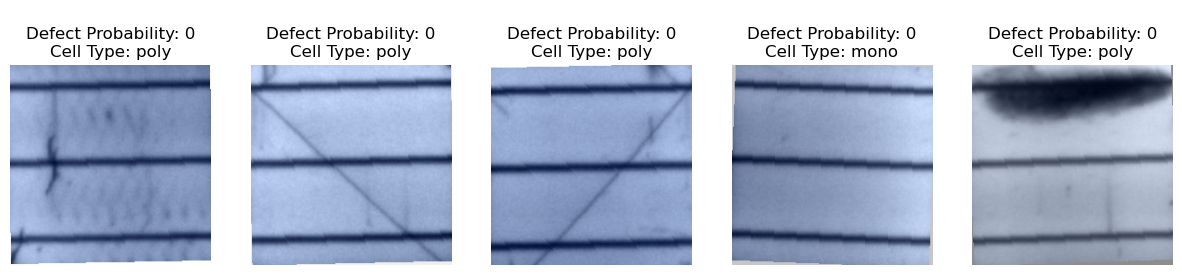

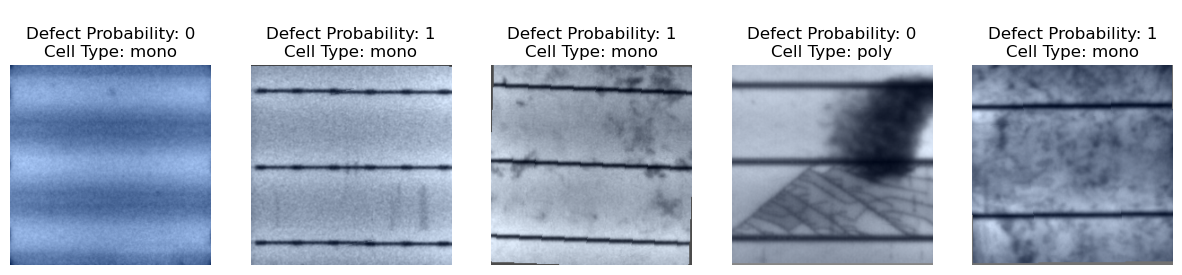

In [89]:

import matplotlib.pyplot as plt

"""
Select a few images to visualize the dataset images, as well as the transforms
"""

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        # Get image, label, cell type
        image, label, cellType = dataset[i]
        cellType = "mono" if cellType == 0 else "poly"

        # Convert image tensor to numpy array for display
        image_np = image.numpy().transpose((1, 2, 0))
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

        # Display the image
        axes[i].imshow(image_np)
        axes[i].axis('off')
        axes[i].set_title(f'\nDefect Probability: {label}\nCell Type: {cellType}')

    plt.show()

show_images(fullDataset) 
show_images(trainData) 

In [67]:
import torch
import torch.nn as nn

"""
Setup our model, criterion, and parameters
Currently using a modified pre-trained resnet18 to take advantage of transfer learning
"""

def closest_probability_class(value):
    probabilities = np.array([0, 1/3, 2/3, 1])
    return min(probabilities, key=lambda x: abs(x - value))

        
class ModifiedResNet(nn.Module):
    """
    This is a modified resnet model in which the final fully connected layer is modified to output
    a single scalar value (the predicted probability of defect).

    In addition, the features going into the final fully connected layer is modified. Namely, we concatenate
    the solar cell type (0 for 'mono', 1 for 'poly') to the feature vector going into the fc player.
    """
    def __init__(self, resnetModel):
        super(ModifiedResNet, self).__init__()
        # Everything except the last linear layer
        self.features = nn.Sequential(*list(resnetModel.children())[:-1])
        
        # Get the number of features going into the last fc layer
        num_ftrs = resnetModel.fc.in_features

        # Redefine the last linear layer / fully connected layer
        # Since we are doing regression, the final output is a scalar value
        self.fc = nn.Linear(num_ftrs + 1, 1)

    def forward(self, image, cellType):
        """
        In addition to the original features being passed into the fully connected layer,
        we also concatenate the solar panel cell type (0 for mono, 1 for poly) to the feature vector
        
        image: 
            The torch tensor image
        
        cellType:
            0 dimensional tensor, where the value is 0 for mono, 1 for poly
        """

        x = self.features(image)
        x = torch.flatten(x, 1)
        

        # Concatenate the additional features
        x = torch.cat((x, cellType), dim=1)

        # Pass through the modified fully connected layer
        x = self.fc(x)
        
        # Round the predicted probability output to the nearest probability class (0, 0.33, 0.66, 1)
        # x = x.apply_(closest_probability_class)

        return x.double()

model_ft = ModifiedResNet(models.resnet18(weights='IMAGENET1K_V1'))
model_ft = model_ft.to(device)

# Since we're doing regression instead of classification, we use MSE instead of Cross Entropy
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [76]:
def train_model(model, dataset_sizes, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            
            for images, cell_types, probabilities in dataloaders[phase]:
                # cell_types is of shape [N], where N is the batch size
                # we need to convert this to shape [N, 1] in order to make it easier to 
                # concatenate the cell_type with the feature vector in the resnet model
                cell_types = cell_types.unsqueeze(1)

                # move all data to training device
                images = images.to(device)
                cell_types = cell_types.to(device)
                probabilities = probabilities.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    prediction = model(images, cell_types)
                    prediction = prediction.squeeze() # make sure output tensor is same shape as labels

                    # output = closest_probability_class(prediction)

                    loss = criterion(prediction, probabilities)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * images.size(dim=0) # TODO: do I need this images.size()?
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f}')
    
    return model


In [75]:
"""
Train our model
"""

dataloaders = {
    'train': trainDataloader,
    'val': valDataLoader,
    'test': testDataloader,
}

image_datasets = {
    'train': trainData,
    'val': valData,
    'test': testData,
}

dataset_sizes = {
    'train': len(trainData),
    'val': len(valData),
    'test': len(testData),
}

model_ft = train_model(
    model_ft,
    dataset_sizes,
    dataloaders,
    criterion=nn.MSELoss(),
    optimizer=optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9),
    scheduler=lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1),
    num_epochs=24,
)

Epoch 0/23
----------
train Loss: 0.0522
val Loss: 0.1150
Epoch 1/23
----------
train Loss: 0.0605
val Loss: 0.1173
Epoch 2/23
----------
train Loss: 0.0585
val Loss: 0.1531
Epoch 3/23
----------
train Loss: 0.0632
val Loss: 0.1411
Epoch 4/23
----------
train Loss: 0.0759
val Loss: 0.1245
Epoch 5/23
----------
train Loss: 0.0631
val Loss: 0.1114
Epoch 6/23
----------
train Loss: 0.0660
val Loss: 0.1236
Epoch 7/23
----------
train Loss: 0.0532
val Loss: 0.1458
Epoch 8/23
----------
train Loss: 0.0464
val Loss: 0.1185
Epoch 9/23
----------
train Loss: 0.0475
val Loss: 0.1206
Epoch 10/23
----------
train Loss: 0.0503
val Loss: 0.1183
Epoch 11/23
----------
train Loss: 0.0570
val Loss: 0.1168
Epoch 12/23
----------
train Loss: 0.0474
val Loss: 0.1065
Epoch 13/23
----------
train Loss: 0.0522
val Loss: 0.1760
Epoch 14/23
----------
train Loss: 0.0526
val Loss: 0.1191
Epoch 15/23
----------
train Loss: 0.0466
val Loss: 0.2155
Epoch 16/23
----------
train Loss: 0.0475
val Loss: 0.1191
Epoch 1